# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0   658k      0  0:04:12  0:04:12 --:--:-- 1455k1k      0  0:05:13  0:02:39  0:02:34 1798k9  0:02:43  0:02:26 1264k04:03  0:03:20  0:00:43  170k
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

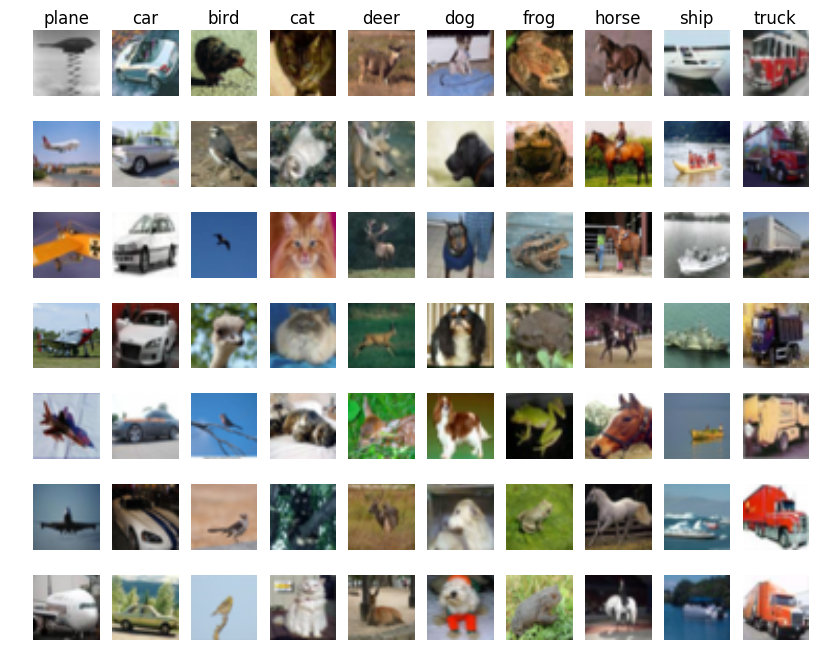

In [3]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?

<Ответ>

**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [4]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer", dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Wish you get fun :)

In [5]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import PadLayer
from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer
from lasagne.nonlinearities import softmax, rectify
from lasagne.layers import batch_norm

def build_cnn(input_var=None, n=5):
    
    # create a residual learning building block with two stacked 3x3 convlayers as in paper
    def residual_block(l, increase_dim=False, projection=False):
        input_num_filters = l.output_shape[1]
        if increase_dim:
            first_stride = (2,2)
            out_num_filters = input_num_filters*2
        else:
            first_stride = (1,1)
            out_num_filters = input_num_filters

        stack_1 = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(3,3), stride=first_stride, nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        stack_2 = batch_norm(ConvLayer(stack_1, num_filters=out_num_filters, filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
        
        # add shortcut connections
        if increase_dim:
            if projection:
                # projection shortcut, as option B in paper
                projection = batch_norm(ConvLayer(l, num_filters=out_num_filters, filter_size=(1,1), stride=(2,2), nonlinearity=None, pad='same', b=None, flip_filters=False))
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, projection]),nonlinearity=rectify)
            else:
                # identity shortcut, as option A in paper
                identity = ExpressionLayer(l, lambda X: X[:, :, ::2, ::2], lambda s: (s[0], s[1], s[2]//2, s[3]//2))
                padding = PadLayer(identity, [out_num_filters//4,0,0], batch_ndim=1)
                block = NonlinearityLayer(ElemwiseSumLayer([stack_2, padding]),nonlinearity=rectify)
        else:
            block = NonlinearityLayer(ElemwiseSumLayer([stack_2, l]),nonlinearity=rectify)
        
        return block

    # Building the network
    l_in = InputLayer(shape=(None, 3, 32, 32), input_var=input_var)

    # first layer, output is 16 x 32 x 32
    l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    
    # first stack of residual blocks, output is 16 x 32 x 32
    for _ in range(n):
        l = residual_block(l)

    # second stack of residual blocks, output is 32 x 16 x 16
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)

    # third stack of residual blocks, output is 64 x 8 x 8
    l = residual_block(l, increase_dim=True)
    for _ in range(1,n):
        l = residual_block(l)
    
    # average pooling
    l = GlobalPoolLayer(l)

    # fully connected layer
    network = DenseLayer(
            l, num_units=10,
            W=lasagne.init.HeNormal(),
            nonlinearity=softmax)

    return network

n = 1
net = build_cnn(input_X, n)

In [6]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net)
print all_weights

[W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, beta, gamma, mean, inv_std, W, b]


In [ ]:
# Loss
all_layers = lasagne.layers.get_all_layers(net)
l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0001
loss = l2_penalty + lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

# Accuracy
params = lasagne.layers.get_all_params(net, trainable=True)
lr = 0.1
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.momentum(loss, params, learning_rate=sh_lr, momentum=0.9)

test_prediction = lasagne.layers.get_output(net, deterministic=True)
accuracy = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_y), dtype=theano.config.floatX)

In [12]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X, target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [13]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float3d2)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [14]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    
    if (epoch + 1) == 41 or (epoch+1) == 61:
        new_lr = sh_lr.get_value() * 0.1
        print("New LR:"+str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

KeyboardInterrupt: 

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 